In [1]:
!nvidia-smi

Fri Apr 12 20:10:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_file_path = '/content/drive/MyDrive/SignatureObjectDetection.zip'
extract_to_directory = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print("Zip file extracted successfully!")

Zip file extracted successfully!


In [4]:
#YOLO Format
#x_center, y_center, bbox_w_n, bbox_h_n

In [5]:
import os
import shutil
import cv2
from PIL import Image

In [6]:
train_images = '/content/TrainImages'
test_images = '/content/TrainGroundTruth'
train_labels = '/content/TestImages'
test_labels = '/content/TestGroundTruth'

In [7]:
def read_image_dimensions(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except FileNotFoundError:
        print("Image file not found.")
        return None, None
    except Exception as e:
        print("Error:", e)
        return None, None

In [8]:
def convert_annotations_to_yolo(images_dir, annotation_dir, output_dir, file_prefix=''):
    os.makedirs(output_dir, exist_ok=True)
    for annotation_file in os.listdir(annotation_dir):
        image_file_name, _ = os.path.splitext(annotation_file)
        image_width, image_height = read_image_dimensions(os.path.join(images_dir, f"{image_file_name}.tif"))

        with open(os.path.join(annotation_dir, annotation_file), 'r') as file:
            lines = file.readlines()
        # Create YOLO format text file
        output_file_path = os.path.join(output_dir, annotation_file)
        with open(output_file_path, 'w') as output_file:
            for line in lines:
                xmin, ymin, xmax, ymax = line.strip().split(',')
                x_center = (int(xmin) + int(xmax)) / 2
                y_center = (int(ymin) + int(ymax)) / 2
                width = int(xmax) - int(xmin)
                height = int(ymax) - int(ymin)

                x_center /= image_width
                y_center /= image_height
                width /= image_width
                height /= image_height
                
                output_file.write(f"0 {x_center} {y_center} {width} {height}\n")


In [9]:
train_images_dir = '/content/TrainImages'
train_annotation_dir = '/content/TrainGroundTruth/'
train_output_dir = 'train_yolo_annotations/'
convert_annotations_to_yolo(train_images_dir, train_annotation_dir, train_output_dir)

test_images_dir = '/content/TestImages'
test_annotation_dir = '/content/TestGroundTruth/'
test_output_dir = 'test_yolo_annotations/'
convert_annotations_to_yolo(test_images_dir, test_annotation_dir, test_output_dir)

In [11]:
# shutil.rmtree('/content/dataset')

In [12]:
os.mkdir('/content/dataset')
os.mkdir('/content/dataset/images')
os.mkdir('/content/dataset/labels')

os.mkdir('/content/dataset/images/train')
os.mkdir('/content/dataset/images/val')


os.mkdir('/content/dataset/labels/train')
os.mkdir('/content/dataset/labels/val')

In [13]:
source_dir = '/content/TrainImages'
target_dir = '/content/dataset/images/train'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [14]:
source_dir = '/content/train_yolo_annotations'
target_dir = '/content/dataset/labels/train'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [15]:
source_dir = '/content/TestImages'
target_dir = '/content/dataset/images/val'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [16]:
source_dir = '/content/test_yolo_annotations'
target_dir = '/content/dataset/labels/val'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [17]:
import os

# Create a folder if it doesn't exist
folder_name = '/content/dataset'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Create a YAML file inside the folder
yaml_content = """
path: /content/dataset/
train: /content/dataset/images/train
val: /content/dataset/images/val

names:
  0: 'signature'
"""

file_path = os.path.join(folder_name, 'data.yaml')
with open(file_path, 'w') as file:
    file.write(yaml_content)

print(f"YAML file created at: {file_path}")

YAML file created at: /content/dataset/data.yaml


In [18]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.2/78.2 GB disk)


In [19]:
from ultralytics import YOLO
from IPython.display import display, Image

In [21]:
model = YOLO('yolov8n.pt')

results = model.train(
   data='/content/dataset/data.yaml',
   epochs=5,
   batch=8,
)

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /content/dataset/labels/train.cache... 660 images, 0 backgrounds, 0 corrupt: 100%|██████████| 660/660 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/dataset/labels/val.cache... 115 images, 0 backgrounds, 0 corrupt: 100%|██████████| 115/115 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.46G      1.908      3.109      1.407          6        640: 100%|██████████| 83/83 [00:31<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        115        130      0.887     0.0923      0.395      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.33G      1.528       2.09      1.216          3        640: 100%|██████████| 83/83 [00:22<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        115        130      0.858      0.792      0.839      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.34G      1.486      1.859      1.222          5        640: 100%|██████████| 83/83 [00:23<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


                   all        115        130      0.789      0.685      0.779      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.34G      1.426      1.681      1.193         10        640: 100%|██████████| 83/83 [00:29<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


                   all        115        130      0.853      0.792      0.879      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.34G      1.339      1.512      1.139          7        640: 100%|██████████| 83/83 [00:23<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]


                   all        115        130      0.899      0.869      0.916      0.614

5 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


                   all        115        130      0.888      0.869      0.916      0.614
Speed: 0.5ms preprocess, 7.6ms inference, 0.0ms loss, 12.4ms postprocess per image
Results saved to runs/detect/train2


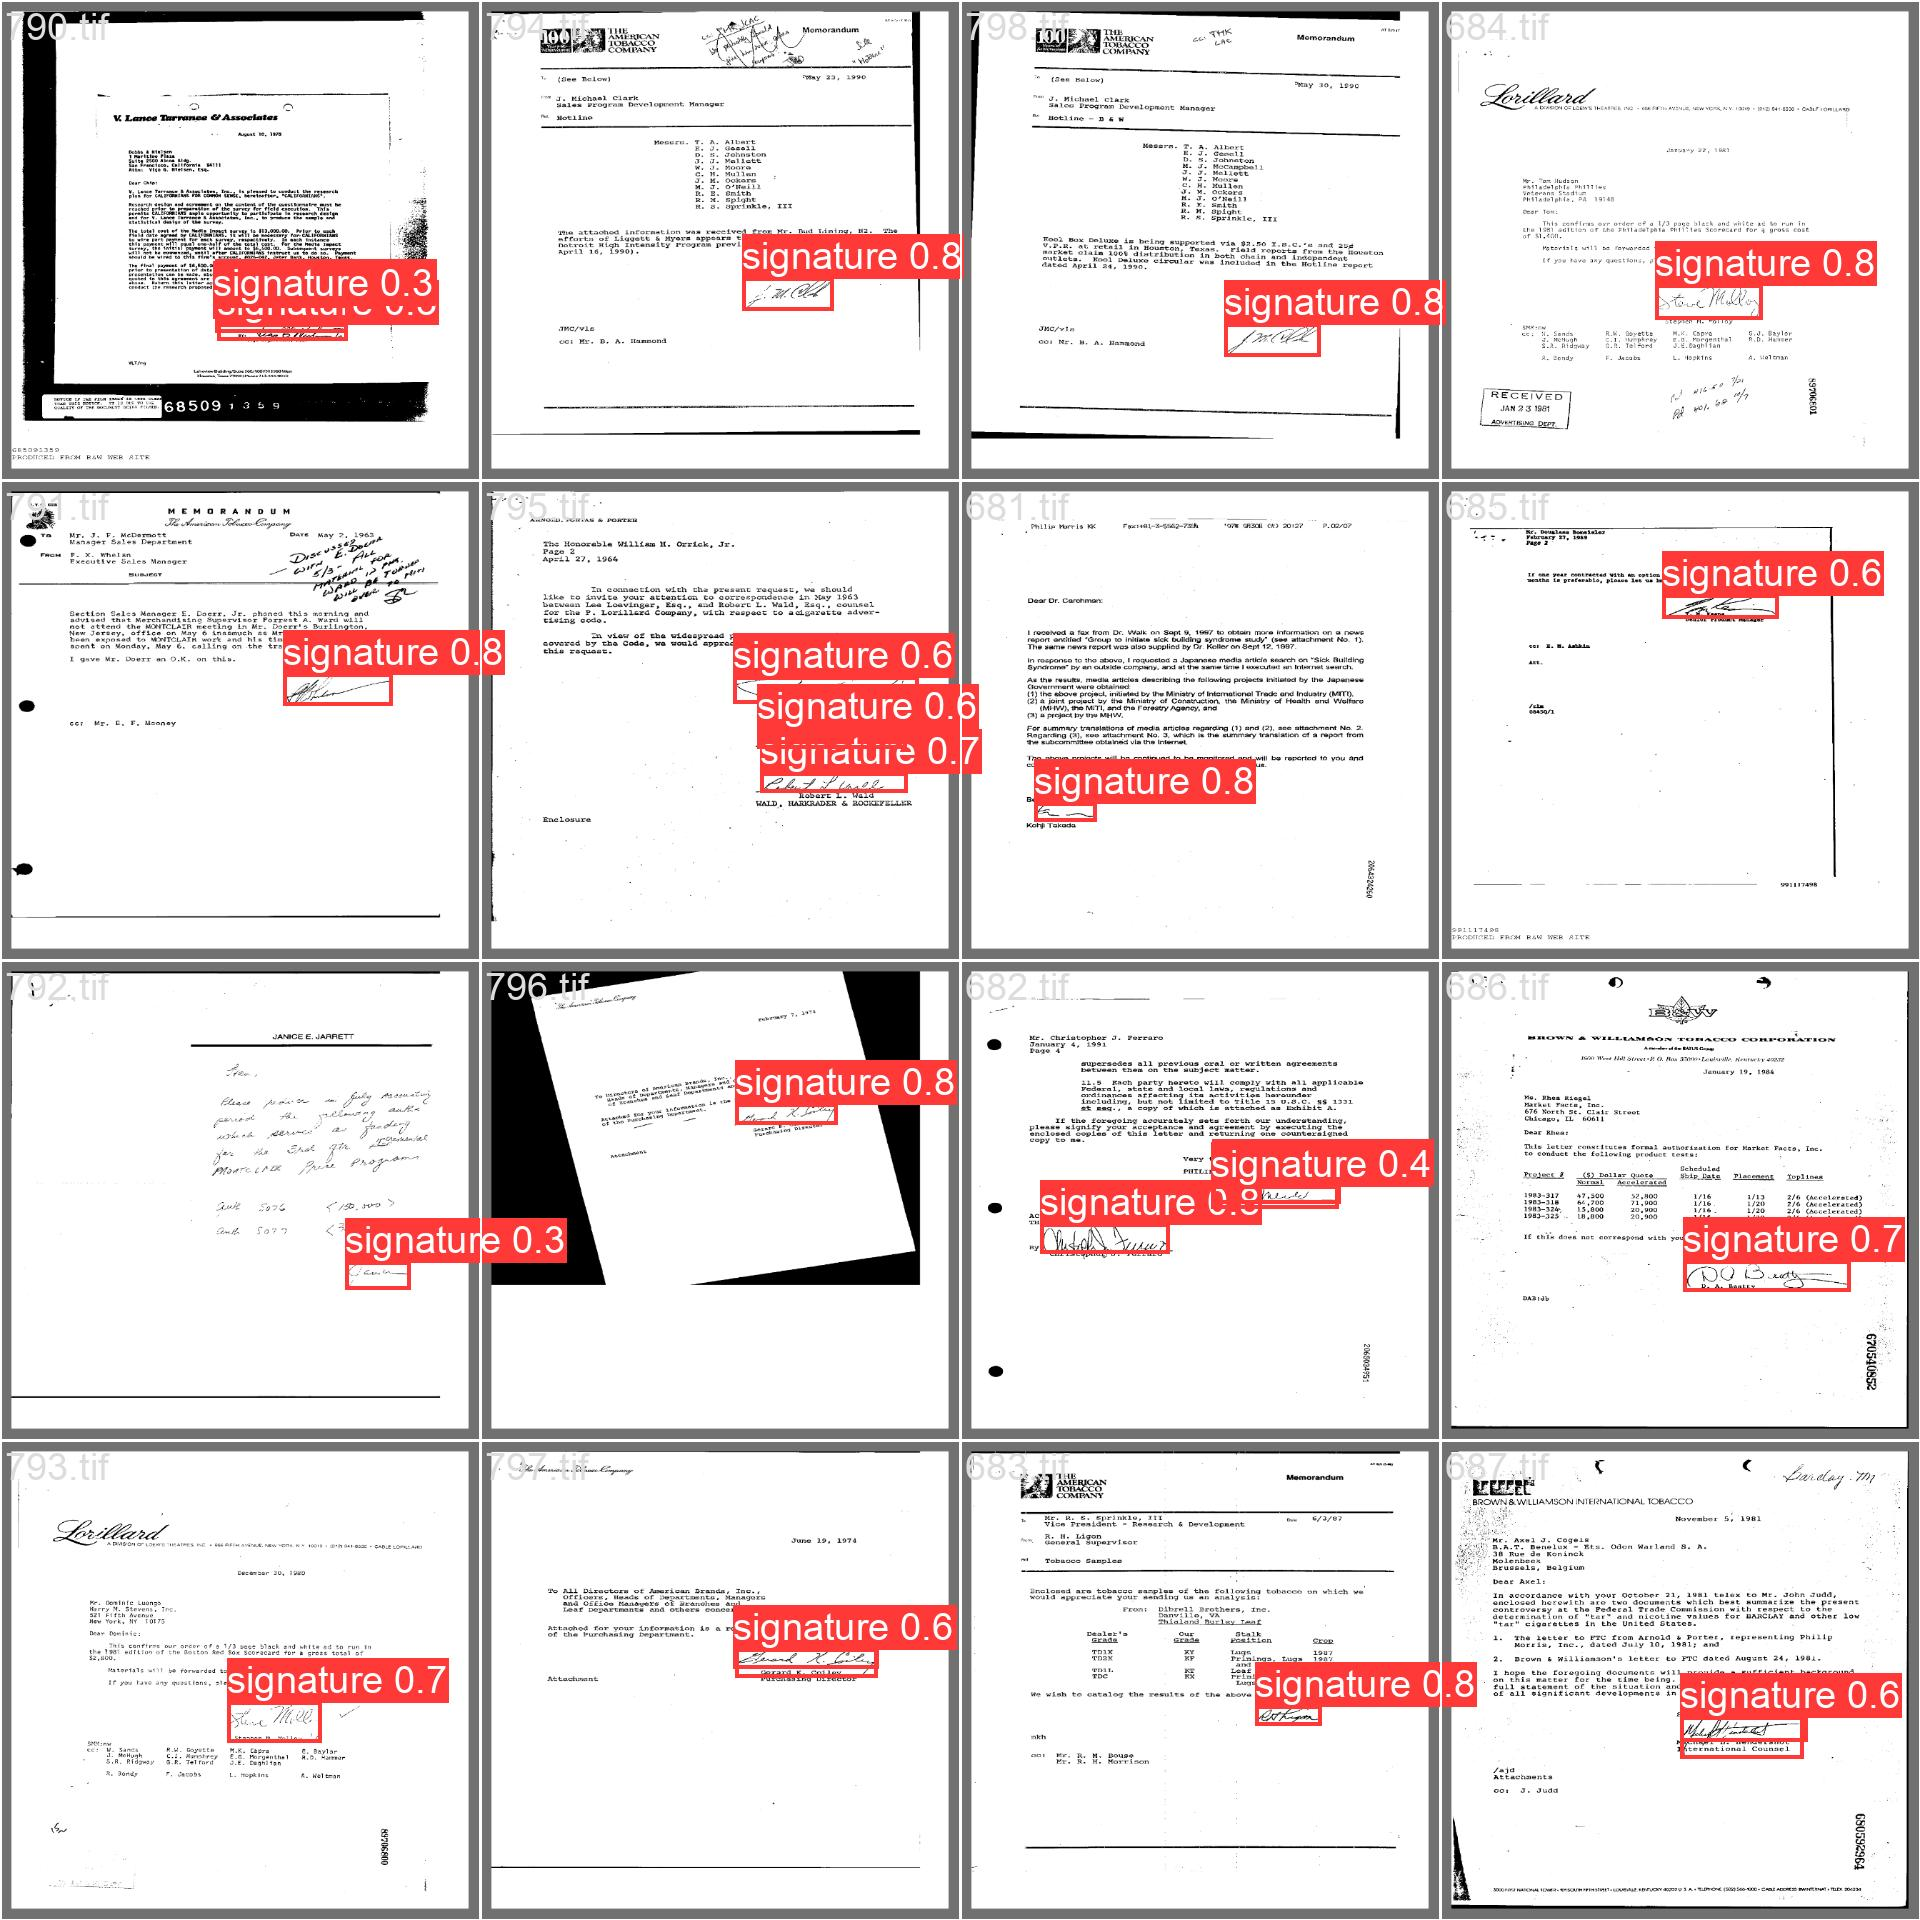

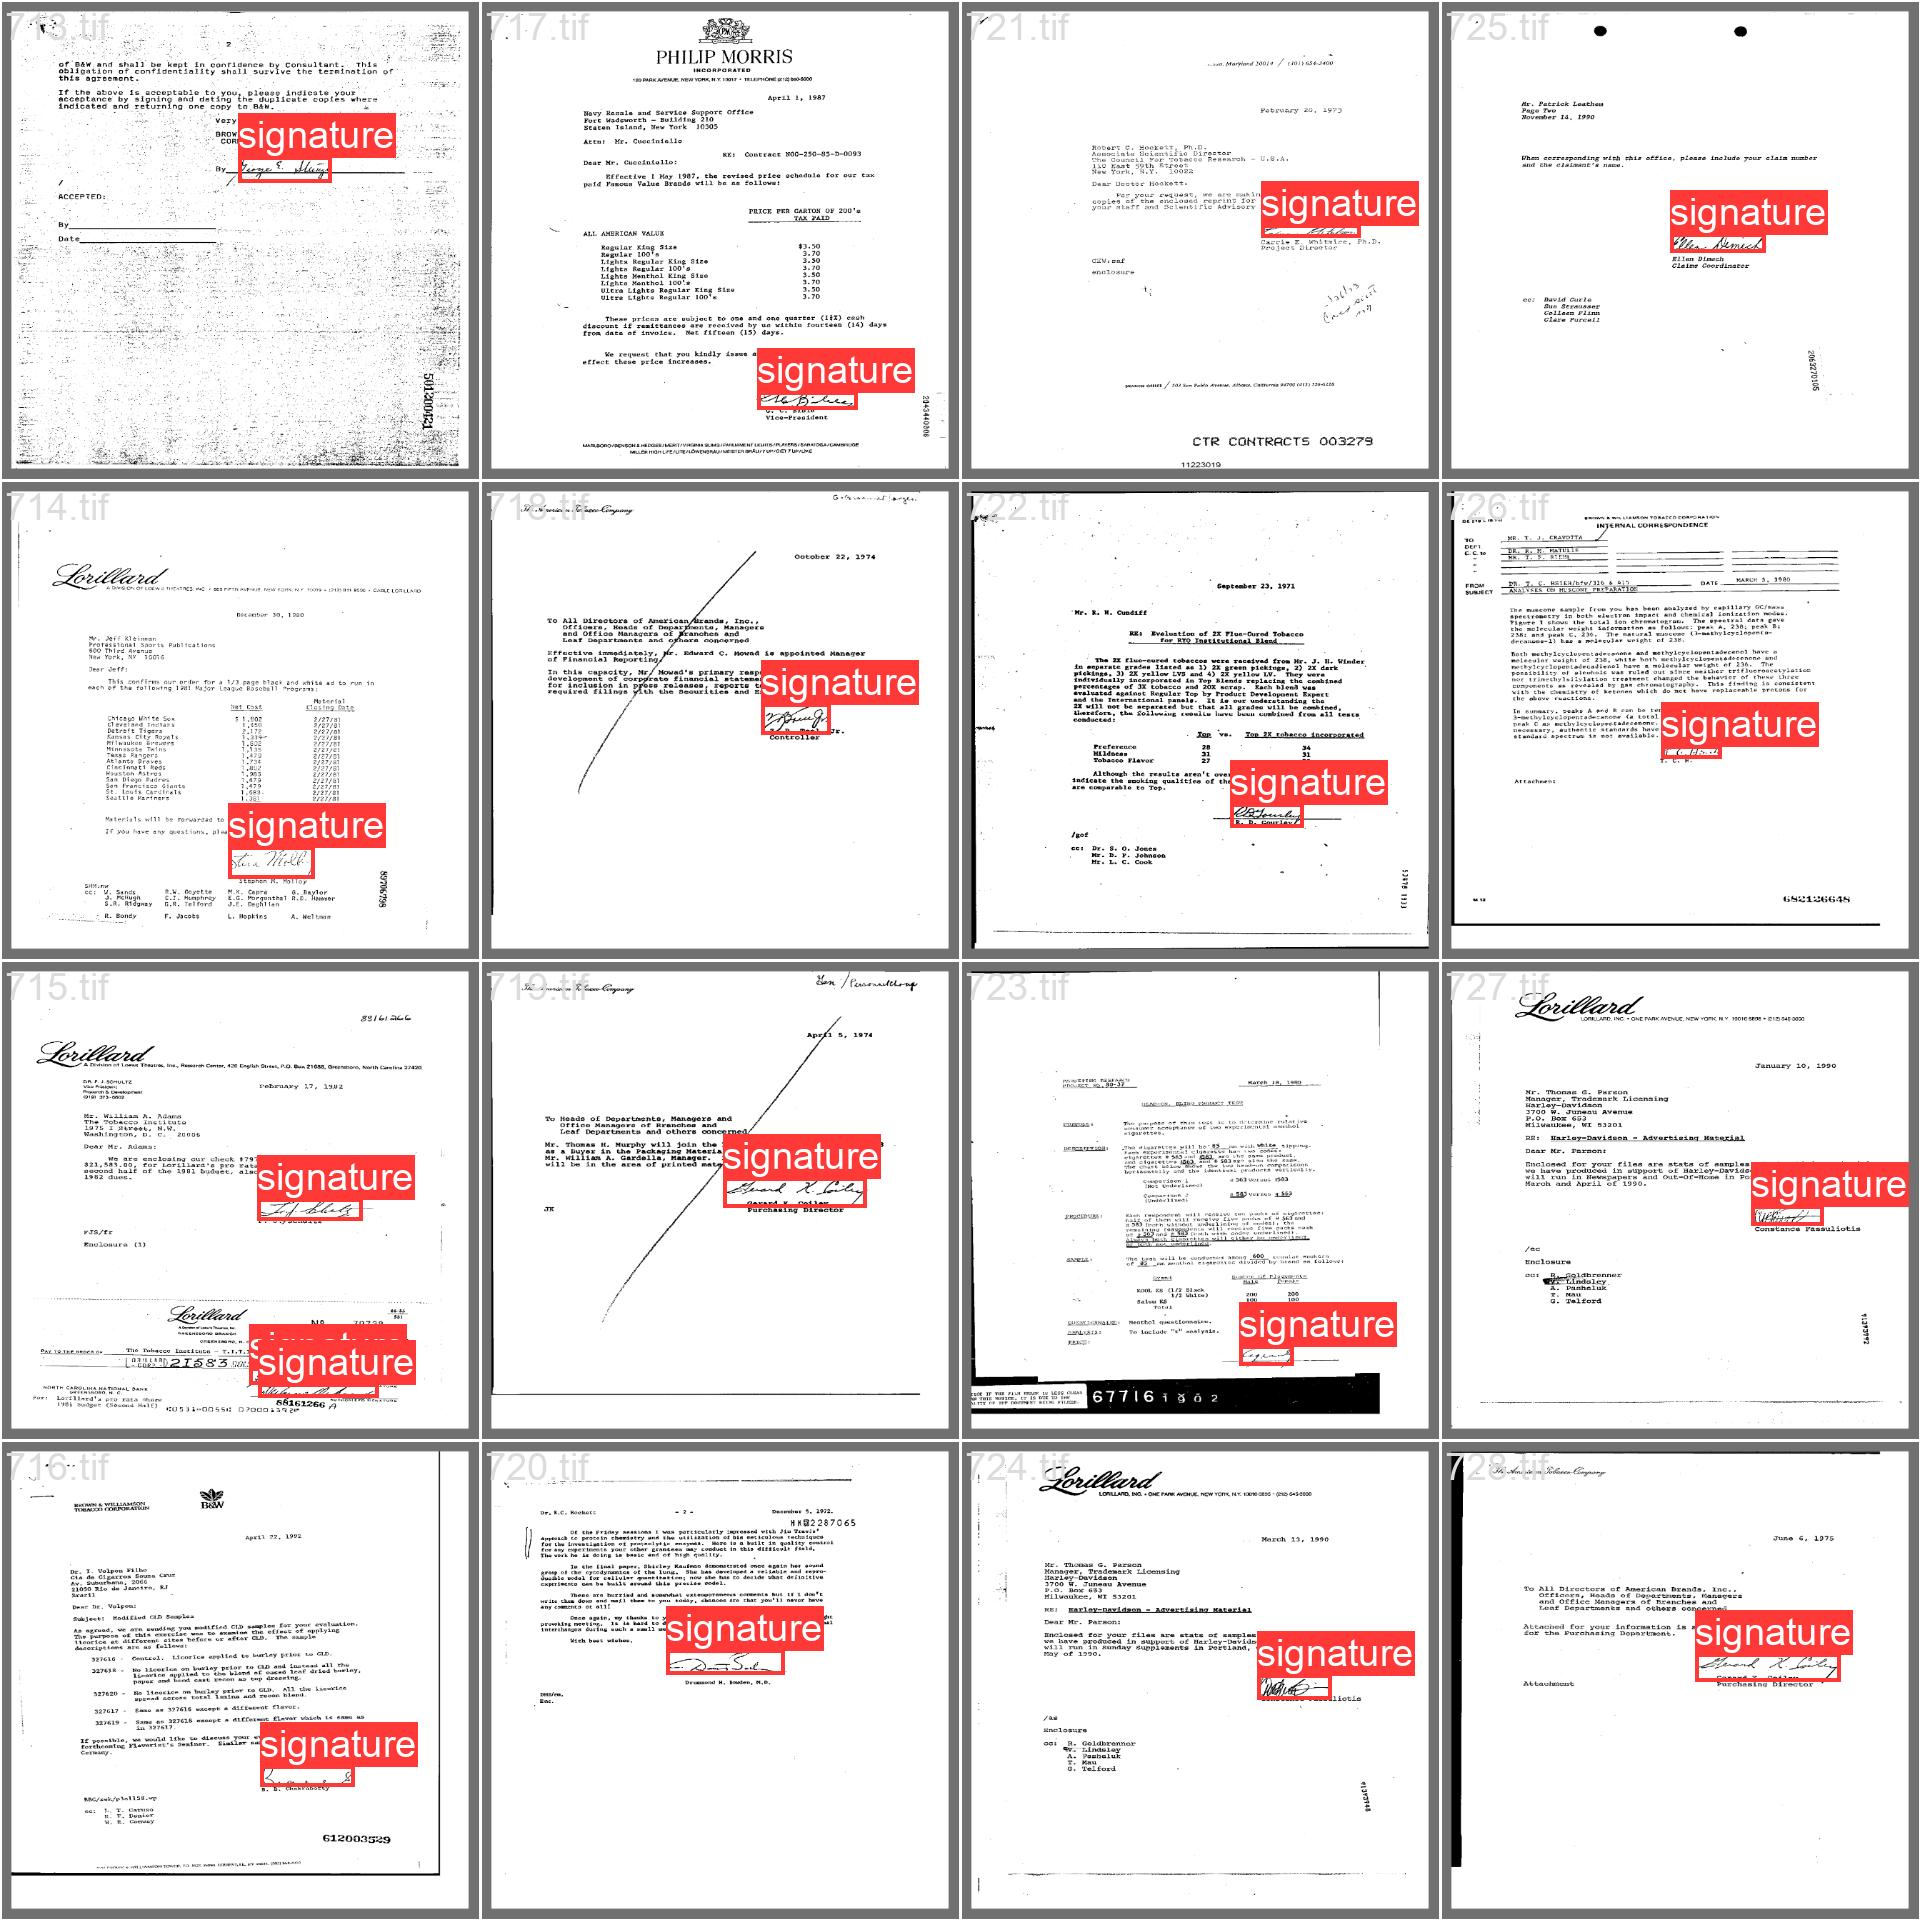

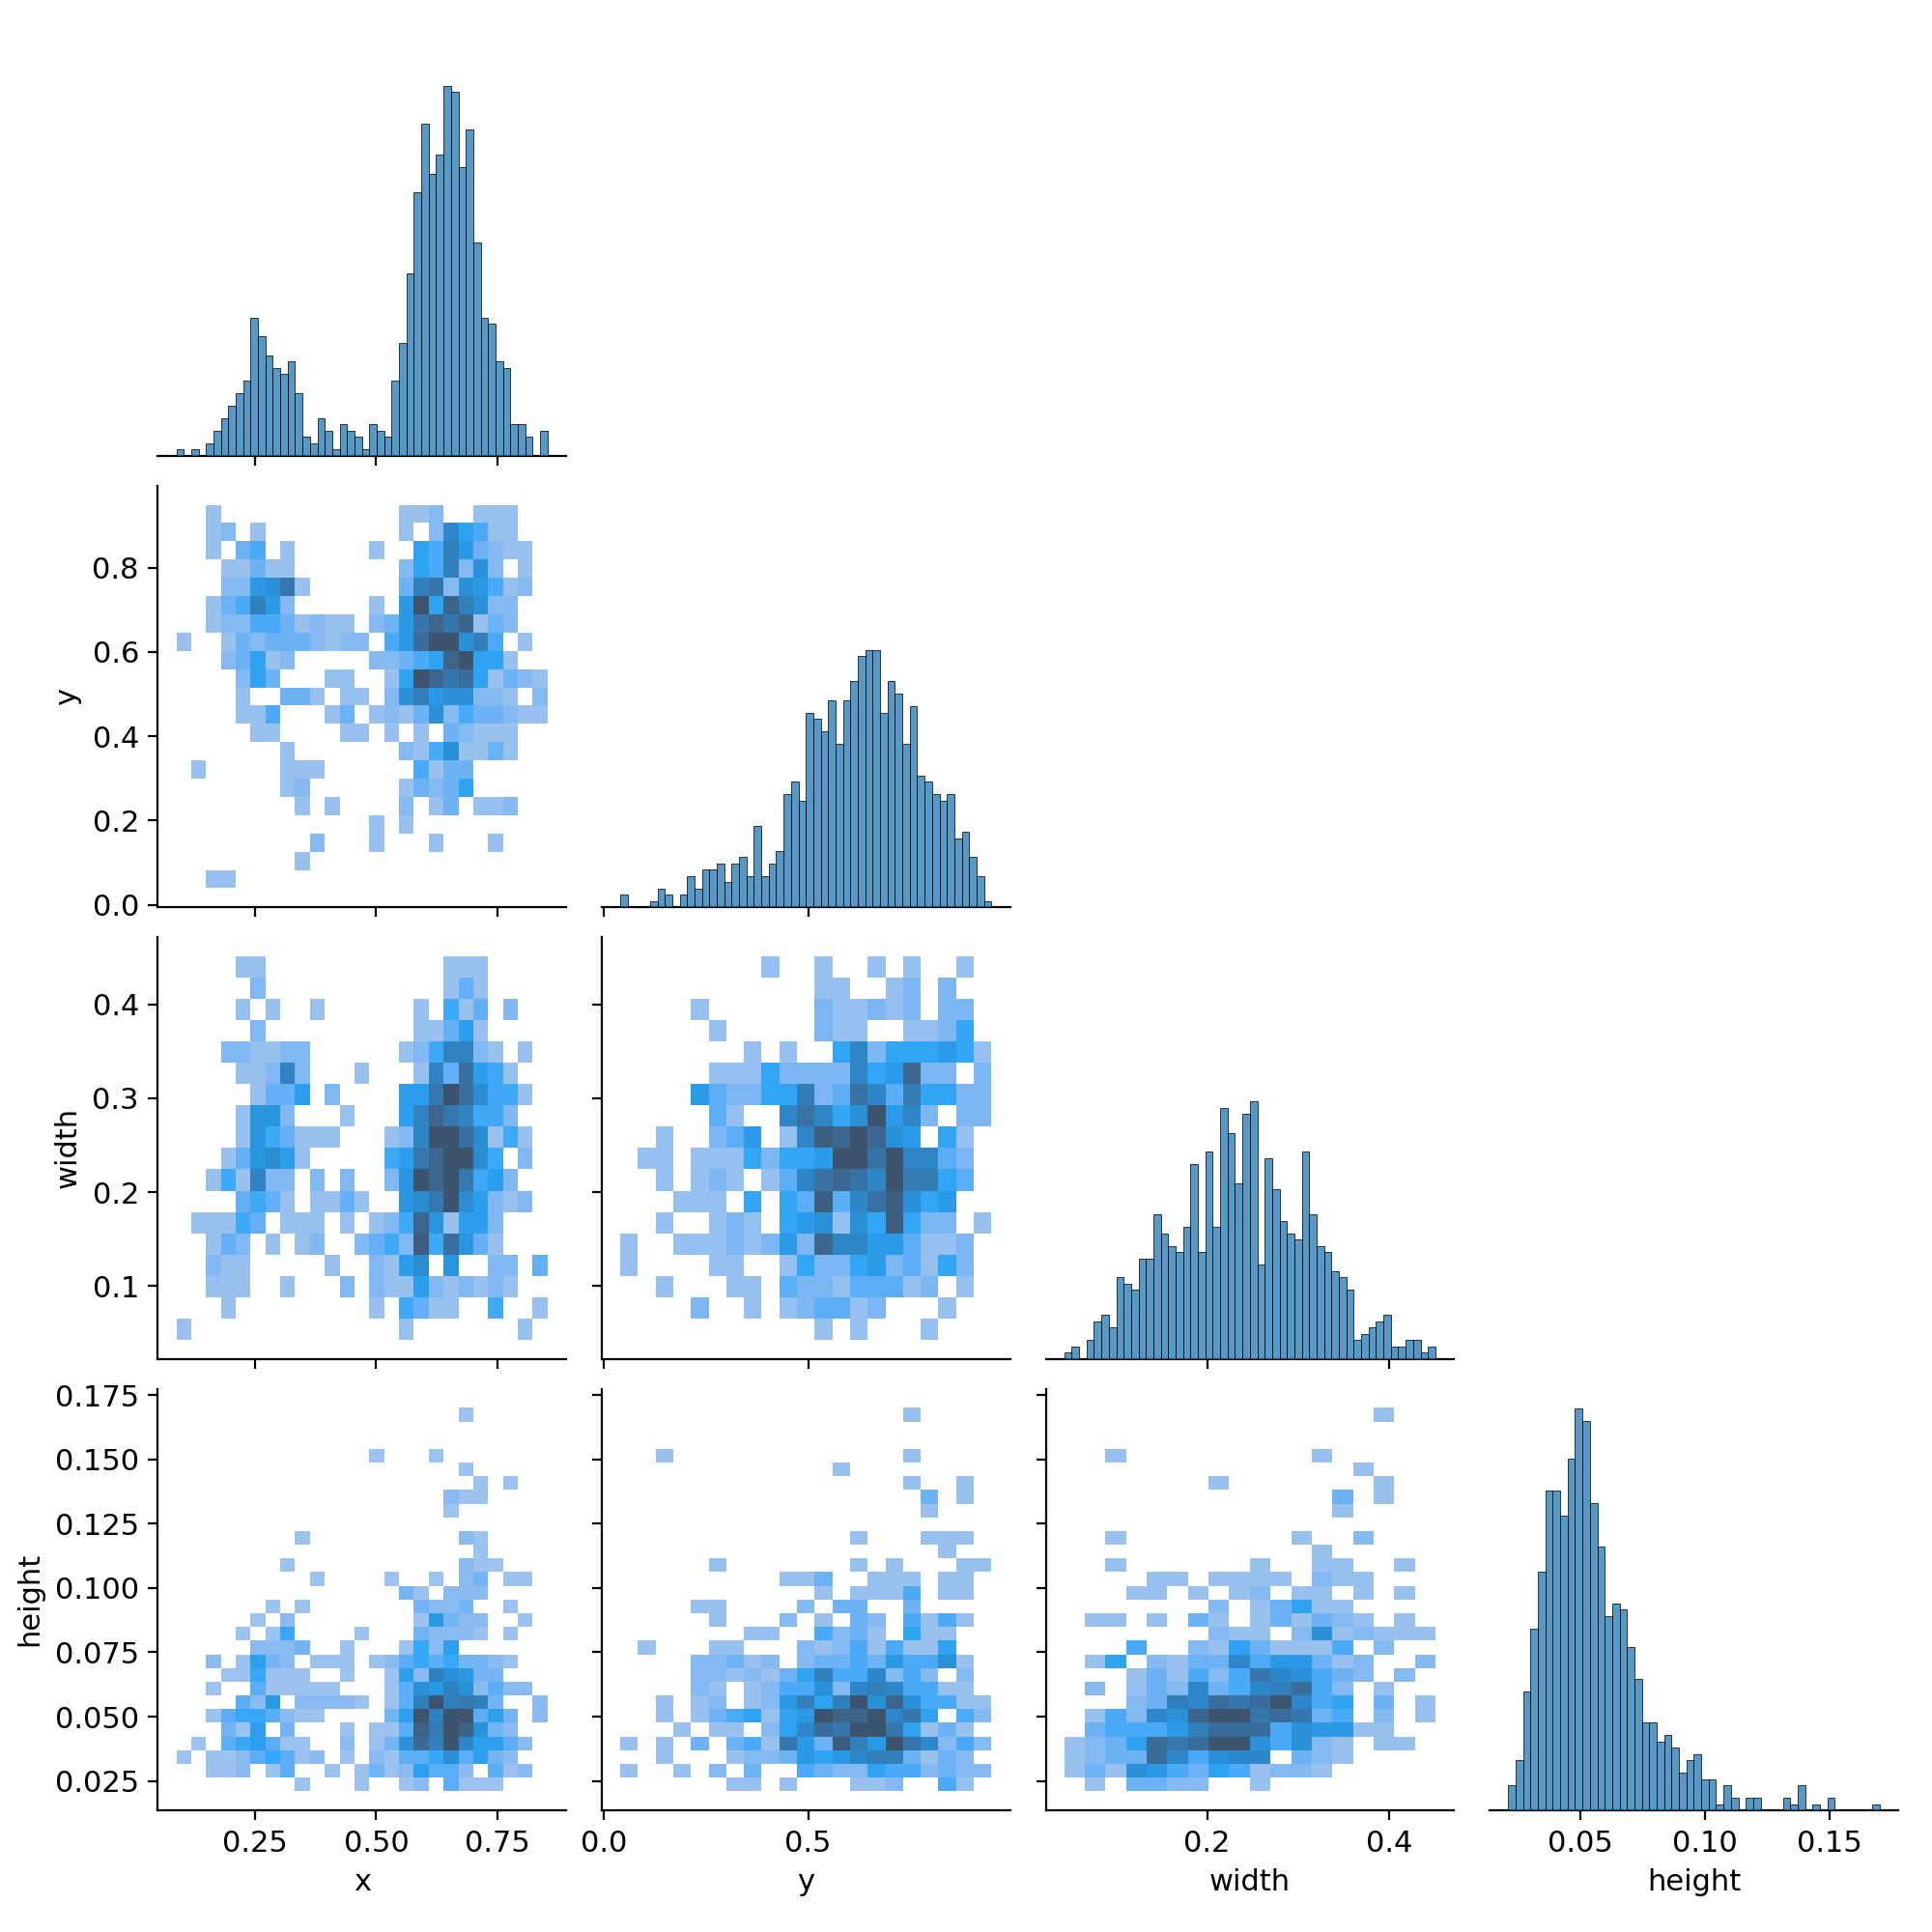

In [27]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/train2/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [30]:
result = model.predict(source="/content/dataset/images/train/11.tif",
              save=True, conf=0.2,iou=0.5)
result = result[0]


image 1/1 /content/dataset/images/train/11.tif: 640x640 1 signature, 16.4ms
Speed: 4.8ms preprocess, 16.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train24


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [241, 241, 241],
        [241, 241, 241],
        [241, 241, 241]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [212, 212, 212],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 14,  14,  14],
        [ 14,  14,  14],
        [ 14,  14,  14],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
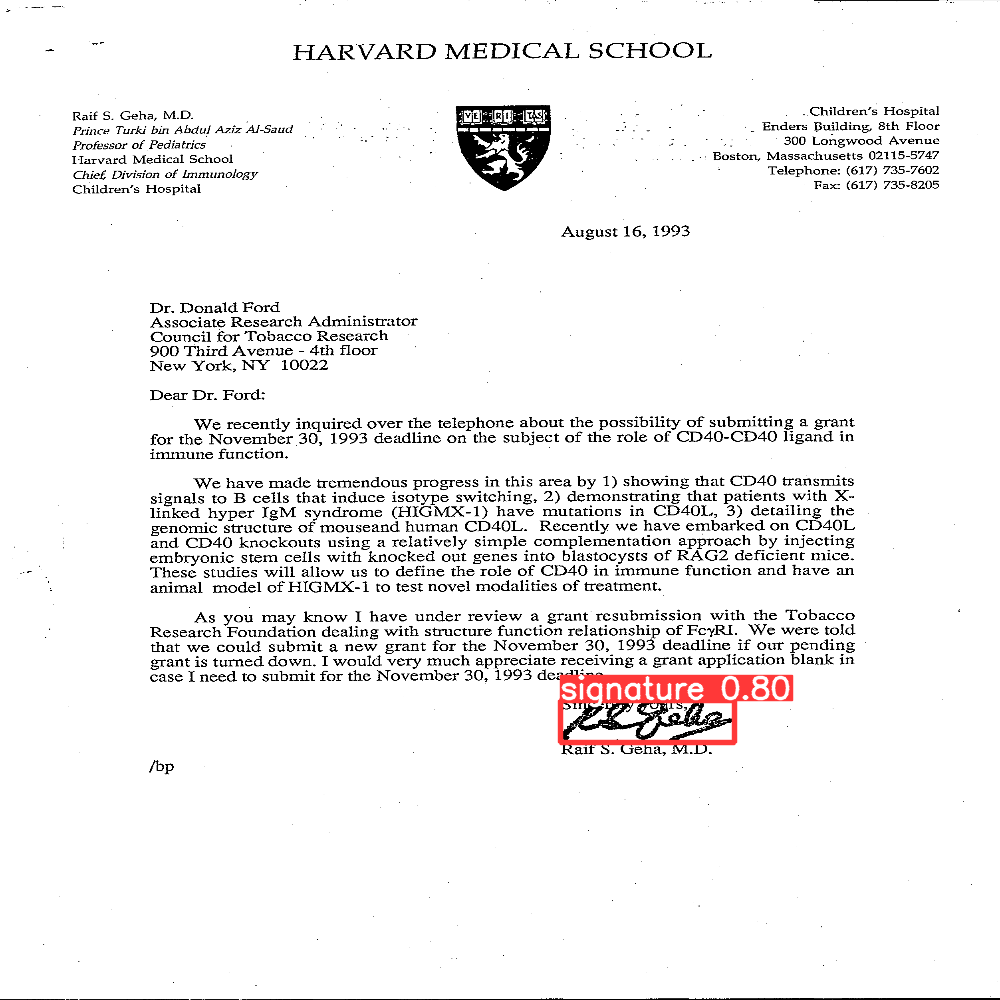

In [31]:
# Plotting results
plot = result.plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
plot

In [32]:
result = model.predict(source="/content/dataset/images/train/300.tif",
              save=True, conf=0.2,iou=0.5)
result = result[0]


image 1/1 /content/dataset/images/train/300.tif: 640x640 1 signature, 22.8ms
Speed: 5.8ms preprocess, 22.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train25


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[162, 162, 162],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[195, 195, 195],
        [ 90,  90,  90],
        [ 90,  90,  90],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
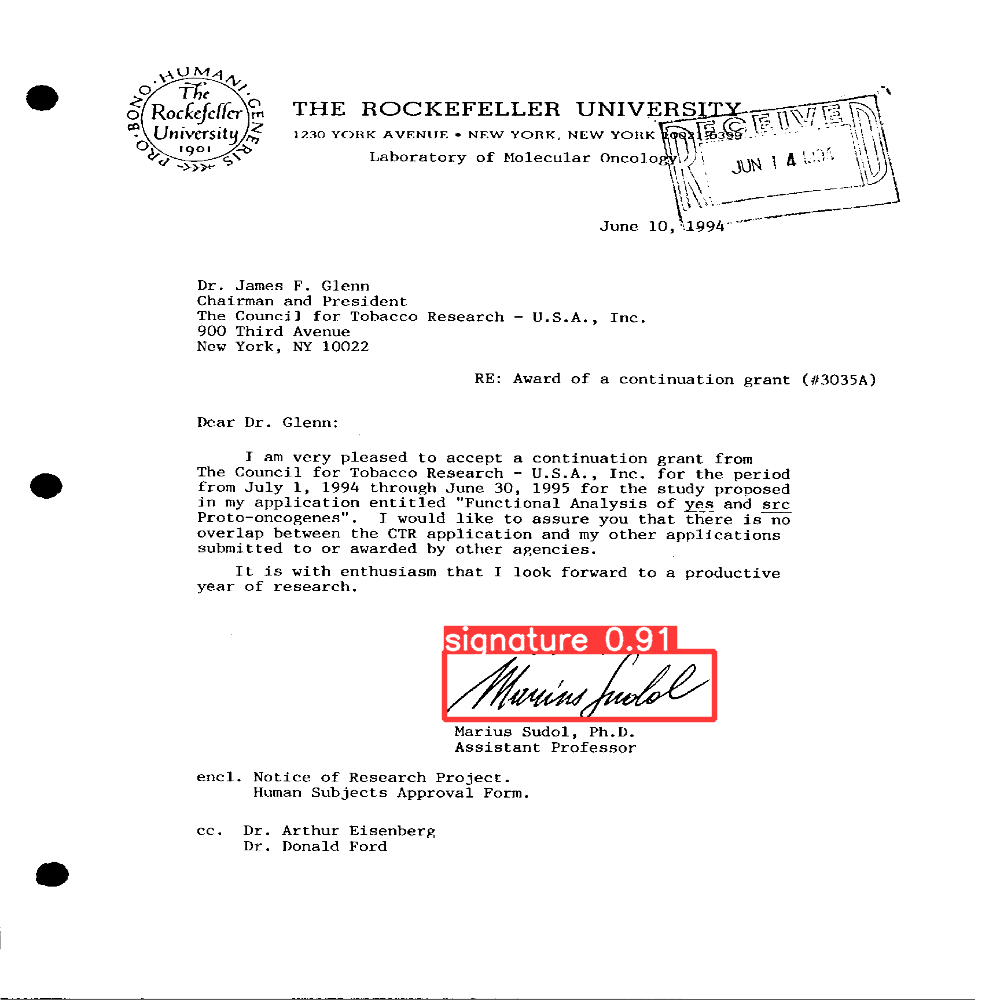

In [33]:
# Plotting results
plot = result.plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
plot

In [40]:
# !zip -r /content/data.zip /content/runs/

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train25/ (stored 0%)
  adding: content/runs/detect/train25/300.tif (deflated 28%)
  adding: content/runs/detect/train23/ (stored 0%)
  adding: content/runs/detect/train23/300.tif (deflated 28%)
  adding: content/runs/detect/train22/ (stored 0%)
  adding: content/runs/detect/train22/11.tif (deflated 23%)
  adding: content/runs/detect/train24/ (stored 0%)
  adding: content/runs/detect/train24/11.tif (deflated 23%)
  adding: content/runs/detect/train2/ (stored 0%)
  adding: content/runs/detect/train2/P_curve.png (deflated 17%)
  adding: content/runs/detect/train2/val_batch0_pred.jpg (deflated 26%)
  adding: content/runs/detect/train2/R_curve.png (deflated 16%)
  adding: content/runs/detect/train2/val_batch2_labels.jpg (deflated 25%)
  adding: content/runs/detect/train2/labels_correlogram.jpg (deflated 40%)
  adding: content/runs/detect/train2/train_batch1.jpg (deflated 14%)
  addin